# Discrete Anomaly Detection

In [1]:
from __future__ import division

import warnings
warnings.filterwarnings("ignore")

import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import seaborn as sns
import math
from sklearn import metrics
from random import randint

import matplotlib.pyplot as plt
from matplotlib import style
%matplotlib inline

## Wrangle Data

### Acquire:

In [2]:
colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']
df_orig = pd.read_csv('http://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8]
)

new = pd.DataFrame([["95.31.18.119", "[21/Apr/2019:10:02:41+0000]", 
                     "GET /api/v1/items/HTTP/1.1", 200, 1153005, np.nan, 
                     "python-requests/2.21.0"],
                    ["95.31.16.121", "[17/Apr/2019:19:36:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 1005, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.15.120", "[18/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 2560, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.19.58", "[19/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 200, 2056327, np.nan, 
                     "python-requests/2.21.0"]], columns=colnames)

df = df_orig.append(new)

In [3]:
df.head()

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
3,97.105.19.58,[16/Apr/2019:19:34:46 +0000],"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
4,97.105.19.58,[16/Apr/2019:19:34:48 +0000],"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13978 entries, 0 to 3
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ip              13978 non-null  object
 1   timestamp       13978 non-null  object
 2   request_method  13978 non-null  object
 3   status          13978 non-null  int64 
 4   size            13978 non-null  int64 
 5   destination     25 non-null     object
 6   request_agent   13978 non-null  object
dtypes: int64(2), object(5)
memory usage: 873.6+ KB


### Parse Datetime:

In [5]:
#remobing backslashes from timestamp
df.timestamp = df.timestamp.str.replace(r'(\[|\])', '', regex=True)
#removing colons
df.timestamp= pd.to_datetime(df.timestamp.str.replace(':', ' ', 1)) 
#setting index
df = df.set_index('timestamp')
df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:42+00:00,97.105.19.58,"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:44+00:00,97.105.19.58,"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:46+00:00,97.105.19.58,"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:48+00:00,97.105.19.58,"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


### Cleanup Text:

In [6]:
# removing quotes from 'request_method', 'request_agent', and 'destination'
for col in ['request_method', 'request_agent', 'destination']:
    df[col] = df[col].str.replace('"', '')

df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/sales?page=81 HTTP/1.1,200,512495,NaN,python-requests/2.21.0
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0
2019-04-16 19:34:44+00:00,97.105.19.58,GET /api/v1/sales?page=82 HTTP/1.1,200,510103,NaN,python-requests/2.21.0
2019-04-16 19:34:46+00:00,97.105.19.58,GET /api/v1/sales?page=83 HTTP/1.1,200,510003,NaN,python-requests/2.21.0
2019-04-16 19:34:48+00:00,97.105.19.58,GET /api/v1/sales?page=84 HTTP/1.1,200,511963,NaN,python-requests/2.21.0


In [7]:
# Removes the detail of the page number
df['request_method'] = df.request_method.str.replace(r'\?page=[0-9]+', '', regex=True)

df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0
2019-04-16 19:34:44+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0
2019-04-16 19:34:46+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0
2019-04-16 19:34:48+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0


### Add Variable - Converting bytes to mb:

In [8]:
#checking status types
df.status.value_counts()

200    13960
499       16
301        2
Name: status, dtype: int64

In [9]:
#checking data types
df.dtypes

ip                object
request_method    object
status             int64
size               int64
destination       object
request_agent     object
dtype: object

In [10]:
df['size_mb'] = [n/1024/1024 for n in df['size']]

In [11]:
df.head()

,ip,request_method,status,size,destination,request_agent,size_mb
timestamp,,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0,0.488753
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0,0.003396
2019-04-16 19:34:44+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0,0.486472
2019-04-16 19:34:46+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0,0.486377
2019-04-16 19:34:48+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0,0.488246


In [12]:
df.describe()

,status,size,size_mb
count,13978.000000,1.397800e+04,13978.000000
mean,200.356703,4.500019e+05,0.429155
std,10.182001,1.614915e+05,0.154010
min,200.000000,0.000000e+00,0.000000
25%,200.000000,5.006370e+05,0.477445
50%,200.000000,5.101380e+05,0.486506
75%,200.000000,5.112910e+05,0.487605
max,499.000000,2.056327e+06,1.961066


## Detecting Anomalies in Discrete Variables

### Finding anomalies in already existing data:

We can easily see some anomalies around IP addresses.

In [13]:
ip_df = pd.DataFrame(df.ip.value_counts(dropna=False)).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_count'})

ip_df2 = pd.DataFrame(df.ip.value_counts(dropna=False)/df.ip.count()).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_proba'})

ip_df = ip_df.merge(ip_df2)

In [14]:
ip_df.sort_values(by='ip_proba', ascending=False).head()

,ip,ip_count,ip_proba
0,97.105.19.58,11999,0.858420
1,173.173.113.51,1059,0.075762
2,72.181.113.170,613,0.043855
3,72.181.105.81,246,0.017599
4,68.201.219.223,21,0.001502


In [15]:
# see those where rate < 1% 
ip_df[ip_df.ip_proba < .01]

,ip,ip_count,ip_proba
4,68.201.219.223,21,0.001502
5,24.26.242.9,21,0.001502
6,52.87.230.102,2,0.000143
7,70.121.214.34,2,0.000143
8,35.175.171.137,2,0.000143
9,35.174.209.2,1,0.000072
10,52.91.30.150,1,0.000072
11,54.172.14.223,1,0.000072
12,45.23.250.16,1,0.000072
13,3.92.201.136,1,0.000072


22
               ip  ip_count  ip_proba
12   45.23.250.16         1  0.000072
13   3.92.201.136         1  0.000072
14  54.145.52.184         1  0.000072
15   3.88.129.158         1  0.000072
16   95.31.18.119         1  0.000072
17   95.31.16.121         1  0.000072
18  52.90.165.200         1  0.000072
19  97.105.15.120         1  0.000072
20  34.229.70.250         1  0.000072
21  34.207.64.242         1  0.000072


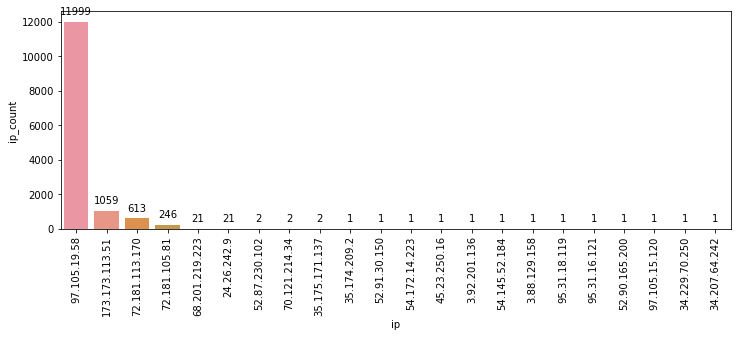

In [16]:
print(len(ip_df))

print(ip_df.tail(10))

plt.figure(figsize=(12, 4))
splot = sns.barplot(data=ip_df, x = 'ip', y = 'ip_count', ci = None)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), 
                   textcoords = 'offset points'
                   )
    plt.xticks(rotation='vertical')

## Detecting anomalies by establishing a baseline and evaluate as new data arrives.

### Establish Baseline:

In [17]:
train = df.loc['2019-04-16 19:34:42':'2019-04-17 12:55:14'][['ip','request_method','status','size','destination','request_agent','size_mb']]

### Compute probabilities based on train sample:

In [18]:
# Probability of discrete/categorical occurence
ip_df = pd.DataFrame(train.ip.value_counts(dropna=False)/train.ip.count()).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_proba'})

ip_df.head()

,ip,ip_proba
0,97.105.19.58,0.858595
1,173.173.113.51,0.075784
2,72.181.113.170,0.043867
3,72.181.105.81,0.017604
4,68.201.219.223,0.001503


### Merge probabilities with all data (train + new data):
- Where the IP address is new, i.e. not seen in the training dataset, fill the probability with a value of 0.

In [19]:
df = df.reset_index().merge(ip_df, on=['ip'], how='left').fillna(value=0).set_index('timestamp')
df.head()

,ip,request_method,status,size,destination,request_agent,size_mb,ip_proba
timestamp,,,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,0,python-requests/2.21.0,0.488753,0.858595
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,0,python-requests/2.21.0,0.003396,0.858595
2019-04-16 19:34:44+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,0,python-requests/2.21.0,0.486472,0.858595
2019-04-16 19:34:46+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,0,python-requests/2.21.0,0.486377,0.858595
2019-04-16 19:34:48+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,0,python-requests/2.21.0,0.488246,0.858595


In [20]:
df.ip_proba.value_counts()

0.858595    11999
0.075784     1059
0.043867      613
0.017604      246
0.001503       42
0.000072       10
0.000143        6
0.000000        3
Name: ip_proba, dtype: int64

## Conditional Probabilities: Probabilities using 2 discrete variables

### Probability of Status given IP Address:
If we are looking for an unexpected status (like authentication failure) from a known/common IP address.

In [21]:
ip_probs = train.groupby('ip').size().div(len(df))

status_given_ip = pd.DataFrame(train.groupby(['ip', 'status']).\
                               size().div(len(train)).\
                               div(ip_probs, 
                                   axis=0, 
                                   level='ip').\
                               reset_index().\
                               rename(index=str, 
                                      columns={0: 'proba_status_given_ip'})
                              )
status_given_ip

,ip,status,proba_status_given_ip
0,173.173.113.51,200,1.000286
1,24.26.242.9,200,1.000286
2,3.88.129.158,200,1.000286
3,3.92.201.136,200,1.000286
4,34.207.64.242,200,1.000286
5,34.229.70.250,200,1.000286
6,35.174.209.2,200,1.000286
7,35.175.171.137,200,1.000286
8,45.23.250.16,200,1.000286
9,52.87.230.102,200,1.000286


In [22]:
ip_status_count = pd.DataFrame(train.groupby(['ip', 'status'])['request_method'].\
                                count().reset_index().\
                                rename(index=str, 
                                       columns={'request_method': 'ip_status_count'}))


ip_status = status_given_ip.merge(ip_status_count)
ip_status.sort_values(by="ip_status_count", ascending=False)

,ip,status,proba_status_given_ip,ip_status_count
19,97.105.19.58,200,0.999119,11984
0,173.173.113.51,200,1.000286,1059
17,72.181.113.170,200,0.997023,611
16,72.181.105.81,200,1.000286,246
1,24.26.242.9,200,1.000286,21
14,68.201.219.223,200,1.000286,21
20,97.105.19.58,499,0.001167,14
7,35.175.171.137,200,1.000286,2
9,52.87.230.102,200,1.000286,2
15,70.121.214.34,200,1.000286,2


### Add these probabilities to original events to detect anomalous events:

In [23]:
df = df.reset_index().merge(ip_status, on=['ip', 'status'], how='left').fillna(value=0).set_index('timestamp')

In [24]:
df.head()

,ip,request_method,status,size,destination,request_agent,size_mb,ip_proba,proba_status_given_ip,ip_status_count
timestamp,,,,,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,0,python-requests/2.21.0,0.488753,0.858595,0.999119,11984.0
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,0,python-requests/2.21.0,0.003396,0.858595,0.999119,11984.0
2019-04-16 19:34:44+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,0,python-requests/2.21.0,0.486472,0.858595,0.999119,11984.0
2019-04-16 19:34:46+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,0,python-requests/2.21.0,0.486377,0.858595,0.999119,11984.0
2019-04-16 19:34:48+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,0,python-requests/2.21.0,0.488246,0.858595,0.999119,11984.0


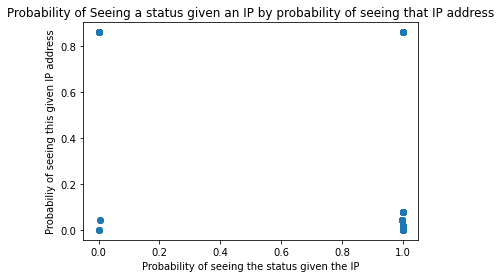

In [25]:
plt.title("Probability of Seeing a status given an IP by probability of seeing that IP address")
plt.xlabel("Probability of seeing the status given the IP")
plt.ylabel("Probabiliy of seeing this given IP address")
plt.scatter(df.proba_status_given_ip, df.ip_proba)
plt.show()

## Exercise

**file name**: discrete_anomaly_detection.py or discrete_anomaly_detection.ipynb

Save this work in your anomaly-detection-exercises repo. Then add, commit, and push your changes.

### Discrete Data + Probability
- Use basic probability to identify anomalous request methods. You will want to make sure the text is normalized in order to reduce the noise.

In [29]:
size_df = pd.DataFrame(df['size'].value_counts(dropna=False)).reset_index().\
                rename(index=str, columns={'index': 'size', 'size': 'size_count'})

In [30]:
size_df2 = pd.DataFrame(df['size'].value_counts(dropna=False)/df['size'].count()).reset_index().\
                rename(index=str, columns={'index': 'size', 'size': 'size_proba'})

In [31]:
size_df = size_df.merge(size_df2)

In [32]:
size_df.sort_values(by='size_proba', ascending=False).head()

,size,size_count,size_proba
0,494819,705,0.050436
1,3561,548,0.039204
2,3659,291,0.020818
3,1328,229,0.016383
4,1787,219,0.015667


In [35]:
# see those where rate < 1% 
size_df[size_df.size_count < 10]

,size,size_count,size_proba
179,130921,3,0.000215
180,48,3,0.000215
181,327529,1,0.000072
182,2560,1,0.000072
183,409449,1,0.000072
184,2056327,1,0.000072
185,1005,1,0.000072
186,343913,1,0.000072
187,126,1,0.000072
188,360297,1,0.000072


191
        size  size_count  size_proba
181   327529           1    0.000072
182     2560           1    0.000072
183   409449           1    0.000072
184  2056327           1    0.000072
185     1005           1    0.000072
186   343913           1    0.000072
187      126           1    0.000072
188   360297           1    0.000072
189   278377           1    0.000072
190  1153005           1    0.000072


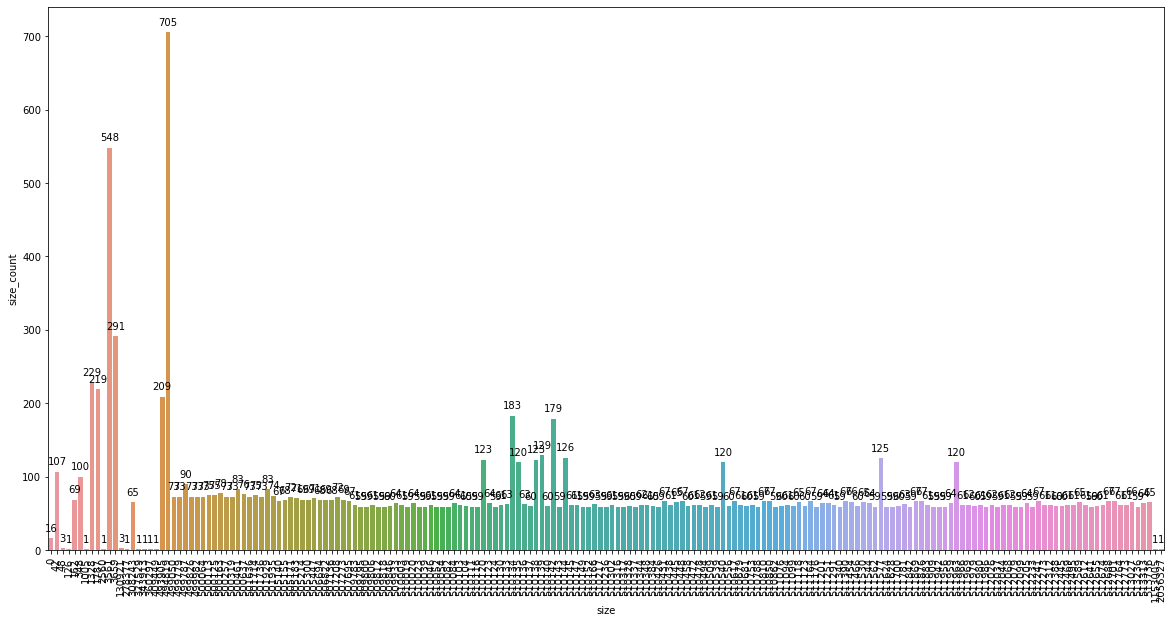

In [39]:
print(len(size_df))

print(size_df.tail(10))

plt.figure(figsize=(20, 10))
splot = sns.barplot(data=size_df, x = 'size', y = 'size_count', ci = None)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), 
                   textcoords = 'offset points'
                   )
    plt.xticks(rotation='vertical')

In [43]:
# Probability of discrete/categorical occurence
size_df = pd.DataFrame(train['size'].value_counts(dropna=False)/train['size'].count()).reset_index().\
                rename(index=str, columns={'index': 'size', 'size': 'size_proba'})

size_df.head()

,size,size_proba
0,494819,0.050451
1,3561,0.039216
2,3659,0.020824
3,1328,0.016388
4,1787,0.015672


In [44]:
df = df.reset_index().merge(size_df, on=['size'], how='left').fillna(value=0).set_index('timestamp')
df.head()

,ip,request_method,status,size,destination,request_agent,size_mb,ip_proba,proba_status_given_ip,ip_status_count,size_proba
timestamp,,,,,,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,0,python-requests/2.21.0,0.488753,0.858595,0.999119,11984.0,0.004365
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,0,python-requests/2.21.0,0.003396,0.858595,0.999119,11984.0,0.039216
2019-04-16 19:34:44+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,0,python-requests/2.21.0,0.486472,0.858595,0.999119,11984.0,0.004365
2019-04-16 19:34:46+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,0,python-requests/2.21.0,0.486377,0.858595,0.999119,11984.0,0.004365
2019-04-16 19:34:48+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,0,python-requests/2.21.0,0.488246,0.858595,0.999119,11984.0,0.008587


In [45]:
df.size_proba.value_counts()

0.004222    2478
0.004365    1769
0.004294    1080
0.004795     938
0.050451     705
0.005224     657
0.004580     640
0.039216     548
0.004651     390
0.008587     360
0.004938     345
0.004437     310
0.020824     291
0.004508     252
0.008802     246
0.016388     229
0.005367     225
0.015672     219
0.014956     209
0.004866     204
0.013096     183
0.012810     179
0.005940     166
0.005152     144
0.005081     142
0.004723     132
0.009231     129
0.009017     126
0.008945     125
0.007657     107
0.007156     100
0.006441      90
0.005582      78
0.005439      76
0.005296      74
0.001145      16
0.000072       6
0.000215       6
0.000000       4
Name: size_proba, dtype: int64

In [46]:
size_mb_df = pd.DataFrame(df['size_mb'].value_counts(dropna=False)).reset_index().\
                rename(index=str, columns={'index': 'size_mb', 'size_mb': 'size_mb_count'})

In [47]:
size_mb_df2 = pd.DataFrame(df['size_mb'].value_counts(dropna=False)/df['size_mb'].count()).reset_index().\
                rename(index=str, columns={'index': 'size_mb', 'size_mb': 'size_mb_proba'})

In [48]:
size_mb_df = size_mb_df.merge(size_mb_df2)

In [49]:
size_mb_df.sort_values(by='size_mb_proba', ascending=False).head()

,size_mb,size_mb_count,size_mb_proba
0,0.471896,705,0.050436
1,0.003396,548,0.039204
2,0.003489,291,0.020818
3,0.001266,229,0.016383
4,0.001704,219,0.015667


In [56]:
# see those where rate < 1% 
size_mb_df[size_mb_df.size_mb_count < 60]

,size_mb,size_mb_count,size_mb_proba
136,0.486480,59,0.004221
137,0.486452,59,0.004221
138,0.486411,59,0.004221
139,0.486392,59,0.004221
140,0.486425,59,0.004221
141,0.486200,59,0.004221
142,0.486195,59,0.004221
143,0.486423,59,0.004221
144,0.486183,59,0.004221
145,0.486178,59,0.004221


191
      size_mb  size_mb_count  size_mb_proba
181  1.099591              1       0.000072
182  0.327981              1       0.000072
183  0.002441              1       0.000072
184  0.390481              1       0.000072
185  0.000120              1       0.000072
186  0.000958              1       0.000072
187  0.312356              1       0.000072
188  1.961066              1       0.000072
189  0.343606              1       0.000072
190  0.265481              1       0.000072


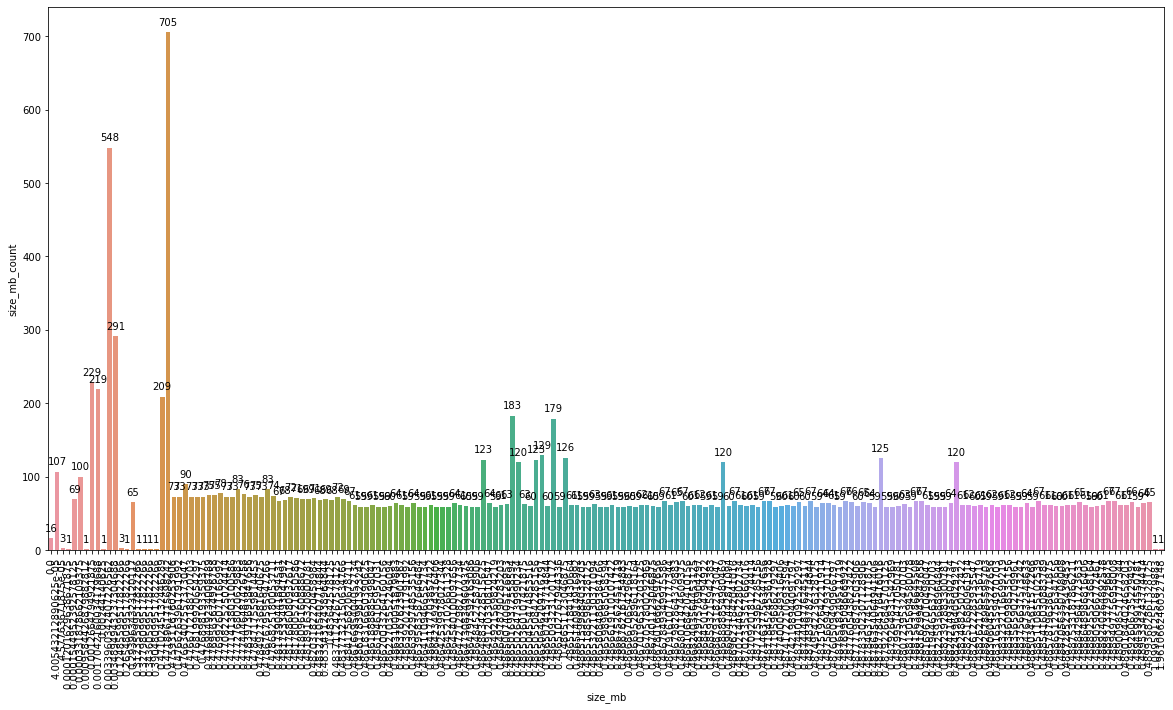

In [57]:
print(len(size_mb_df))

print(size_mb_df.tail(10))

plt.figure(figsize=(20, 10))
splot = sns.barplot(data=size_mb_df, x = 'size_mb', y = 'size_mb_count', ci = None)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), 
                   textcoords = 'offset points'
                   )
    plt.xticks(rotation='vertical')